In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from control import *
%matplotlib inline

In [2]:
sns.set_color_codes(palette='dark')
sns.set(style="whitegrid")

In [3]:
np.random.seed(0)

In [4]:
# define valve spool parameters
Ts = 0.01
m2 = 0.1
J = 10
Km = 2
Kc = 5
Ra = 1
La = 0.5
r = 5e-3
b2 = 25
b2f = 250
k1 = 2500

In [5]:
A1 = np.array([[0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, -Ra/La, -Kc/La],
    [0, 0, Km/(J+m2*r**2), -b2/(J+m2*r**2)]])
A2 = np.array([[0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, -Ra/La, -Kc/La],
    [0, 0, Km/(J+m2*r**2), -b2f/(J+m2*r**2)]])
B = np.array([[0, 0, 1/La, 0]]).transpose()
C = np.array([[0, 1, 0, 0]]) # change
D = 0

In [6]:
sysSS = ss(A1, B, C, D)
sysSSf = ss(A2, B, C, D)

In [7]:
tf1 = tf(sysSS)
print(tf1)


 8.882e-16 s + 0.4
-------------------
s^3 + 4.5 s^2 + 7 s



In [8]:
tf1 = c2d(tf(sysSS), Ts)
tf2 = c2d(tf(sysSSf), Ts)

print(tf1.den[0][0][1:])
print(tf1.num[0][0][1:])

[-2.95531304  2.91131053 -0.95599749]
[2.60735149e-07 6.44543841e-08]


/home/bsilva/.local/lib/python3.6/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [9]:
fac = 1e7 #change
thn = np.concatenate((tf1.den[0][0][1:], fac*tf1.num[0][0][:]), axis=0)
thf = np.concatenate((tf2.den[0][0][1:], fac*tf2.num[0][0][:]), axis=0)

print(thn)
print(thf)

[-2.95531304  2.91131053 -0.95599749  0.6592105   2.60735149  0.64454384]
[-2.75882438  2.52220392 -0.76337954  0.62383267  2.33507008  0.54506852]


In [10]:
# number of measurements
T = 20
t = np.arange(0, T+Ts/2, Ts)
N = len(t)

sig = 0.01 # noise corrupting measurements

print(N)

2001


In [11]:
# model parameters
a1 = np.concatenate((thn[0]*np.ones((1000,1)),
                        thf[0]*np.ones((1001,1))), axis=0)
a2 = np.concatenate((thn[1]*np.ones((1000,1)),
                        thf[1]*np.ones((1001,1))), axis=0)
a3 = np.concatenate((thn[2]*np.ones((1000,1)),
                        thf[2]*np.ones((1001,1))), axis=0)
b1 = np.concatenate((thn[3]*np.ones((1000,1)),
                        thf[3]*np.ones((1001,1))), axis=0)
b2 = np.concatenate((thn[4]*np.ones((1000,1)),
                        thf[4]*np.ones((1001,1))), axis=0)
b3 = np.concatenate((thn[5]*np.ones((1000,1)),
                        thf[5]*np.ones((1001,1))), axis=0)

print(a1[0])

[-2.95531304]


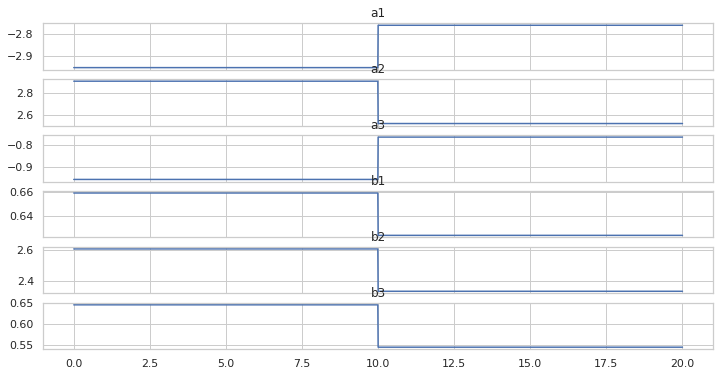

In [12]:
# plot parameters
fig,axes = plt.subplots(nrows=6, ncols=1, figsize=(12,6))

axes[0].set_title("a1")
axes[0].plot(t,a1,color='b')

axes[1].set_title("a2")
axes[1].plot(t,a2,color='b')

axes[2].set_title("a3")
axes[2].plot(t,a3,color='b')

axes[3].set_title("b1")
axes[3].plot(t,b1,color='b')

axes[4].set_title("b2")
axes[4].plot(t,b2,color='b')

axes[5].set_title("b3")
axes[5].plot(t,b3,color='b')

In [39]:
yr = np.zeros((N,1))
u = np.array(100*np.sin(2*np.pi*t)).reshape(N,1)

for k in range(4,N): # change
    phi = np.concatenate(([-yr[k-1]], [-yr[k-2]], [-yr[k-3]] , [u[k-1]], [u[k-2]], [u[k-3]]), axis=1).transpose()
    th = np.concatenate(([a1[k]], [a2[k]], [a3[k]], [1/fac*b1[k]], [1/fac*b2[k]], [1/fac*b3[k]]),\
                        axis=1).transpose()

    yr[k] = np.dot(phi.transpose(), th)
    
y = yr + sig*np.random.rand(N,1) # measurements (corrupted by noise)

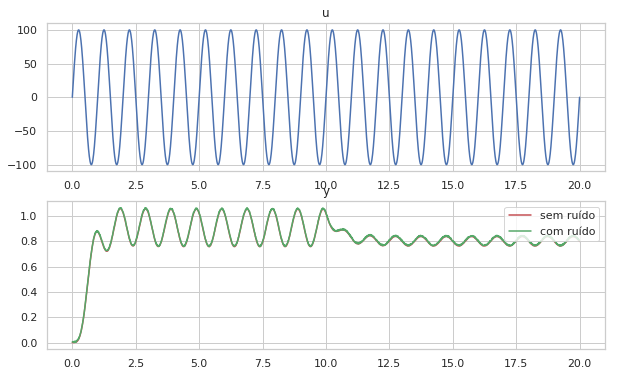

In [14]:
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

axes[0].set_title("u")
axes[0].plot(t,u,color='b')

axes[1].set_title("y")
axes[1].plot(t,yr,color='r',label='sem ruído')
axes[1].plot(t,y,color='g',label='com ruído')
axes[1].legend(loc=1)

In [108]:
# perform RLS

# initialize parameters
P = 1e1*np.identity(len(thn)) # P initial condition
th = thn # theta initial condition
lambd = 0.99 # forgetting factor
yh = np.zeros((N,1)) # prediction
e = np.zeros((N,1)) # prediction error

In [109]:
a1h = np.zeros((N,1))
a2h = np.zeros((N,1))
a3h = np.zeros((N,1))
b1h = np.zeros((N,1))
b2h = np.zeros((N,1))
b3h = np.zeros((N,1))

In [110]:
# strategy = 1 # RLS
# strategy = 2 # random walk
# strategy = 3 # forgetting factor
strategy = 4 # cov res

In [114]:
for k in range(4,N):
    # Step 2
    phi = np.array([-y[k-1], -y[k-2], -y[k-3], u[k-1], u[k-2], u[k-3]]) # regression vector

    # Step 3
    th2 = th.reshape(phi.shape)
    
    th2[3:6] = 1/fac*th2[3:6]
    yh[k] = np.dot(phi.transpose(), th2)
    e[k] = y[k] - yh[k]
    
    # Step 4
    if (strategy == 3): # forgetting factor
        K = np.dot(P, phi)/(lambd+np.dot(phi.transpose(),np.dot(P, phi)))
    
    else:
        K = np.dot(P, phi)/(1+np.dot(phi.transpose(),np.dot(P, phi)))

    # Step 5
    th = th + np.dot(K, e[k]) # Kalman filter (almost)
    
    # Step 6    
    if (strategy == 1): # RLS
        P = P - np.dot(K, np.dot(P, phi).transpose())
    
    elif (strategy == 2): # random walk
        P = P - np.dot(K, np.dot(P, phi).transpose())
        P = P/2 # reduce amplitude of elements
        p = len(th) + 1
        q = np.trace(P)/p
        Q = q*np.identity(len(P))
        #print(Q)
        P = np.add(P, Q)
        #print(P)
    
    elif (strategy == 3): # forgetting factor
        P = (1/lambd)*(P - np.dot(K, np.dot(P, phi).transpose()))
    
    elif (strategy == 4): # forgetting factor
        if (t[k] == 10):
            P = 5e3*np.identity(len(th))
        else:
            P = (1/lambd)*(P - np.dot(K, np.dot(P, phi).transpose()))
    
    # store estimated parameters for plotting
    a1h[k] = th[0]
    a2h[k] = th[1]
    a3h[k] = th[2]
    b1h[k] = th[3]
    b2h[k] = th[4]
    b3h[k] = th[5]

(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)

(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)

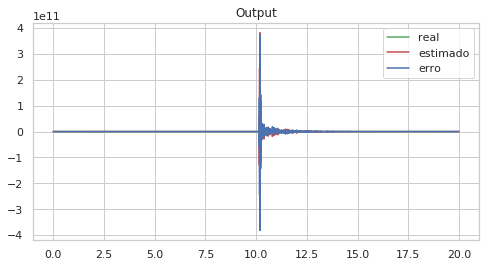

In [112]:
# plot output: real vs estimated and residual
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Output")
axes.plot(t,yr,color='g',label="real")
axes.plot(t,yh,color='r',label="estimado")
axes.plot(t,e,color='b',label="erro")
#axes.set_ylim([0,1])
axes.legend(loc=1)

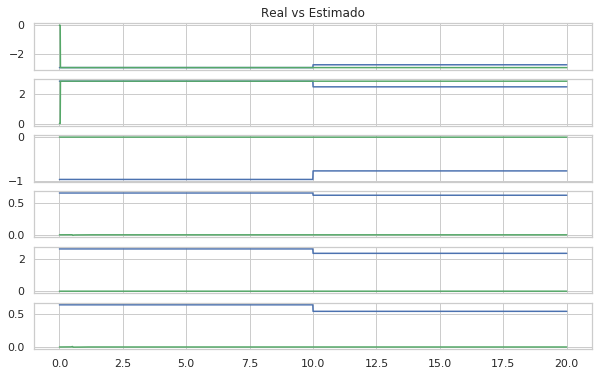

In [106]:
# plot output: real vs estimated
fig,axes = plt.subplots(nrows=6, ncols=1, figsize=(10,6))

axes[0].set_title("Real vs Estimado")
axes[0].plot(t,a1,color='b',label="real")
axes[0].plot(t,a1h,color='g',label="estimado")

axes[1].plot(t,a2,color='b',label="real")
axes[1].plot(t,a2h,color='g',label="estimado")

axes[2].plot(t,a3,color='b',label="real")
axes[2].plot(t,a3h,color='g',label="estimado")

axes[3].plot(t,b1,color='b',label="real")
axes[3].plot(t,b1h,color='g',label="estimado")

axes[4].plot(t,b2,color='b',label="real")
axes[4].plot(t,b2h,color='g',label="estimado")

axes[5].plot(t,b3,color='b',label="real")
axes[5].plot(t,b3h,color='g',label="estimado")